# Project title: Diabet Prediction [notebook 'Process_Data_and_EDA']

## Authors: Denys Herasymuk & Yaroslav Morozevych

In [ ]:
!pip3 install pandas
!pip3 install numpy
!pip3 install sklearn
!pip3 install seaborn
!pip3 install matplotlib

In [4]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Inspect Dataset

In [355]:
df = pd.read_csv('./data/diabetes.csv')

In [334]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


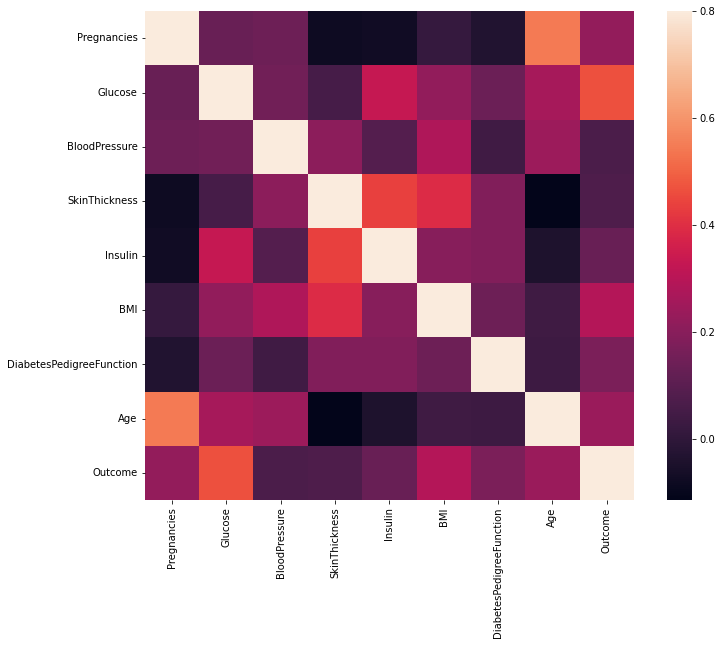

In [335]:
# Correlation matrix
corrmat = df.corr()

# Plot the heatmap of a correlation matrix
fig = plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [123]:
print(corrmat)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.017683                 -0.033523   
Glucose                   0.331357  0.221

As we can see, the features that have some positive correlation to having diabetes are:
- Pregnancies
- Glucose
- Insulin
- BMI
- DiabetesPedigreeFunction
- Age

## Exploratory Data Analysis (EDA)
Before we dive into the investigation of the relations of our data, there are some things we need to know about diabetes. There are basically 4 types of diabetes:
1. **Type 1**: If you have type 1 diabetes, your pancreas does’t produce insulin (meaning that the insulin production can even be 0). As a result, you must take insulin every day. If you don’t, you’ll get very sick or you could die.
2. **Type 2**: With type 2 diabetes, your body makes insulin but your cells don’t respond to it normally. They don’t take in glucose from your bloodstream as well as they once did, which leads to higher blood sugar levels. Over time, type 2 diabetes makes your body produce less insulin, which further raises your blood sugar levels.
3. **Gestational diabetes**: Some women develop gestational diabetes late in their pregnancies. In gestational diabetes, pregnancy-related hormones may interfere with how insulin works. This condition normally disappears after the pregnancy ends. However, if you’ve had gestational diabetes, you’re at greater risk of developing type 2 diabetes in the future
4. **Pre-diabetes**: If you have prediabetes, your body makes insulin but doesn’t use it properly. As a result, your blood glucose levels are raised, though not as high as they would be if you had type 2 diabetes.

So what we need to take into consideration when inspecting our features:
- High level of insulin doesn't guarantee that you are safe from getting down with diabetes.
- Pregnancy increases a risk of getting down with diabetes.
- Insulin level close or equal to 0 can be the cause of Type 1 diabetes.
- Our main feature is **Glucose** as it has the most correlation with getting down with diabetes.

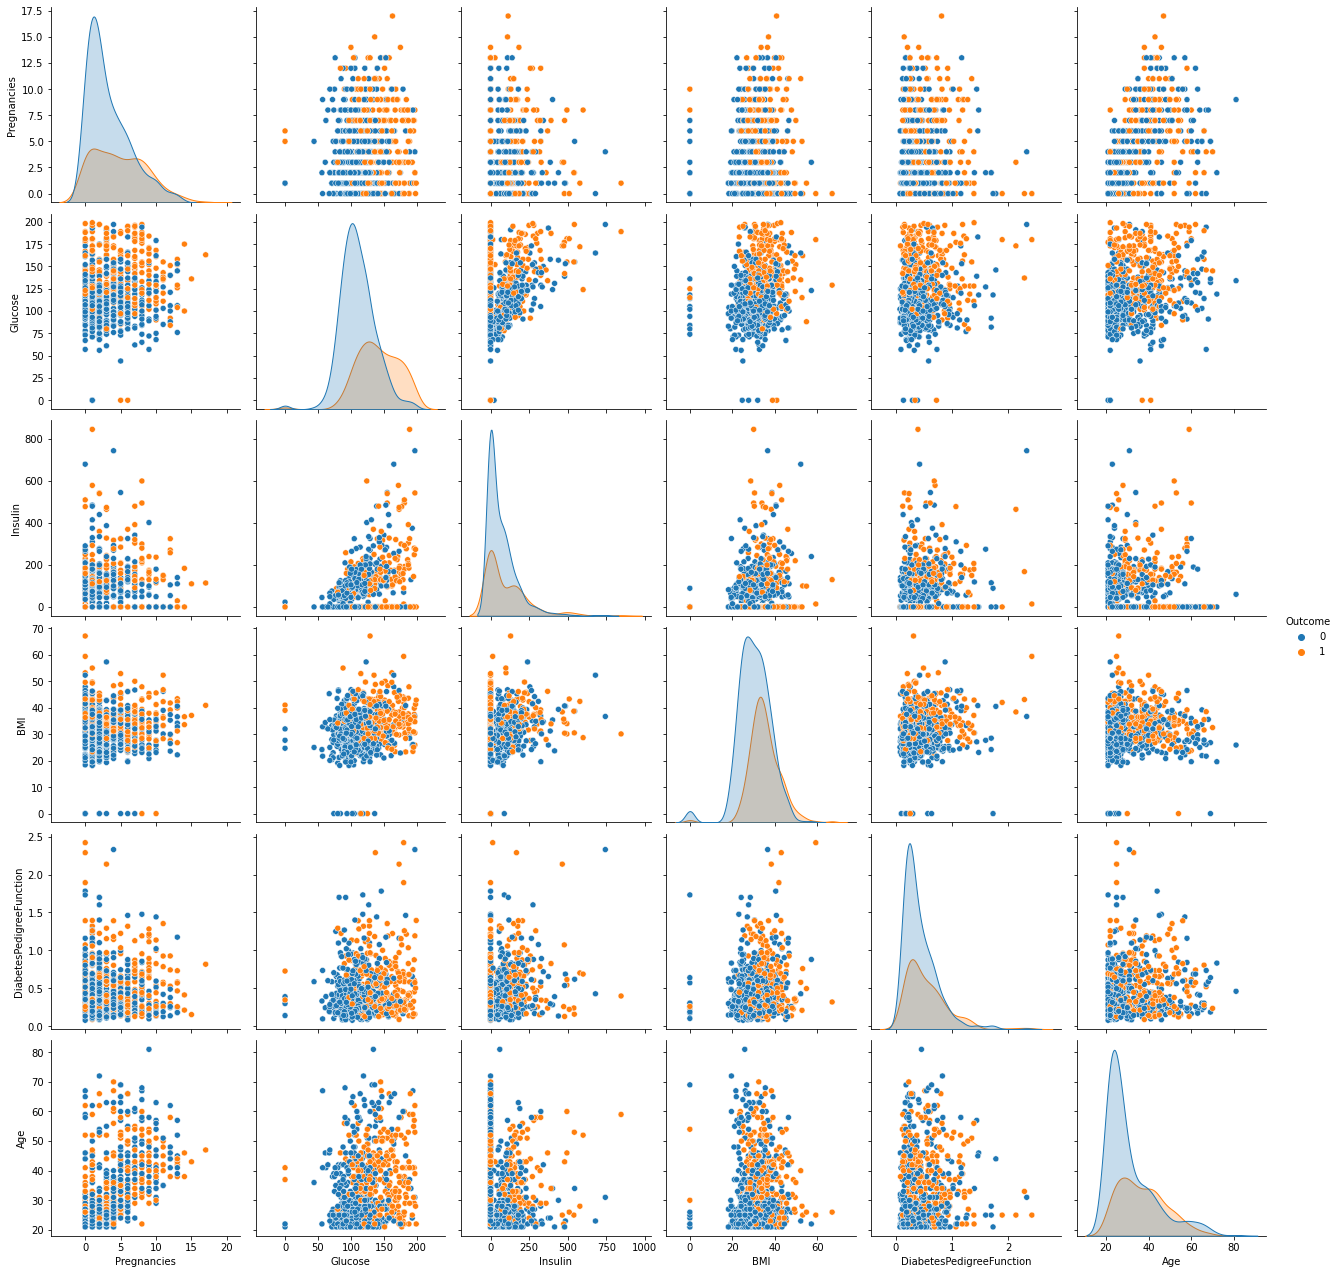

In [122]:
# Include only the columns that have sufficient correlation with the 'Outcome'.
cols = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "Outcome"]
# Plot the relationship between all features using 'Outcome' as a visual metric.
sns.pairplot(df[cols], height=3.0, hue="Outcome")

### Feature Engineering
Given the key aspects, we can create a new feature **DiabetesRisk** that will, given the weights of each key aspect, evaluate the risk of coming down with diabetes.

In [356]:
# Those thresholds are taken from EDA analysis.
GLU_THRESHOLD = 130
BMI_THRESHOLD = 32
AGE_THRESHOLD_RANGE = [30, 60]
INS_THRESHOLD_RANGE = [40, 125]

# Given weights are taken from the correlation matrix (Glucose row).
GLU_WEIGHT = 0.46 # Glucose
INS_WEIGHT = 0.33 # Insulin
AGE_WEIGHT = 0.26 # Age
BMI_WEIGHT = 0.22 # BMI
PRG_WEIGHT = 0.07 # Pregnancies


def risk_eval(row):
    """
    Calculate the risk of getting down with diabetes based on the
    Glucose level in relationship with Insulin, Age, BMI.

    :param row: (np.ndarray) - list of ['Glucose', 'BMI', 'Insulin', 'Age'] values.
    :return: (float) - risk of having diabetes.
    """
    glucose, bmi, insulin, age, pregnancies = row[0], row[1], row[2], row[3], row[4]

    risk = 0 # there is a very low risk.
    # Determine the risk of coming down with diabetes given inputs.
    risk += GLU_WEIGHT if glucose > GLU_THRESHOLD else 0
    risk += BMI_WEIGHT if bmi > BMI_THRESHOLD else 0
    risk += AGE_WEIGHT if AGE_THRESHOLD_RANGE[0] < age < AGE_THRESHOLD_RANGE[1] else 0
    risk += INS_WEIGHT if insulin < INS_THRESHOLD_RANGE[0] or insulin > INS_THRESHOLD_RANGE[1] else 0
    risk += PRG_WEIGHT * pregnancies if PRG_WEIGHT * pregnancies < 1 else 1
    return risk

In [357]:
# Add new feature to the data frame.
df["DiabetesRisk"] = df[["Glucose", "BMI", "Insulin", "Age", "Pregnancies"]].apply(risk_eval, axis=1) # passes row-wise
df.head(20)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,DiabetesRisk
0,6,148,72,35,0,33.6,0.627,50,1,1.69
1,1,85,66,29,0,26.6,0.351,31,0,0.66
2,8,183,64,0,0,23.3,0.672,32,1,1.61
3,1,89,66,23,94,28.1,0.167,21,0,0.07
4,0,137,40,35,168,43.1,2.288,33,1,1.27
5,5,116,74,0,0,25.6,0.201,30,0,0.68
6,3,78,50,32,88,31.0,0.248,26,1,0.21
7,10,115,0,0,0,35.3,0.134,29,0,1.25
8,2,197,70,45,543,30.5,0.158,53,1,1.19
9,8,125,96,0,0,0.0,0.232,54,1,1.15


In [358]:
new_corrmat = df.corr()
print(new_corrmat)

                          Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   
DiabetesRisk                 0.720713  0.563465       0.207094      -0.016854   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535

## Scale & Normalize Data

In [361]:
from sklearn.preprocessing import StandardScaler

# separate the features
features = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
feature_data = df.loc[:, features].values

# scale and center data (mean = 0, variance = 1)
scaled_data = StandardScaler().fit_transform(feature_data)

# show the result
scaled_df = pd.DataFrame(data = scaled_data, columns = features)
scaled_df.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-6.476301e-17,-9.251859e-18,-3.006854e-17,2.590520e-16,2.451743e-16,1.931325e-16,-2.590520e-16,7.401487e-17
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-3.783654e+00,-6.928906e-01,-4.060474e+00,-1.189553e+00,-1.041549e+00,-1.766465e+00,-7.321202e-01
25%,-8.448851e-01,-6.852363e-01,-6.928906e-01,-5.955785e-01,-6.889685e-01,-7.862862e-01,-8.323827e-01,-7.321202e-01
50%,-2.509521e-01,-1.218877e-01,-4.280622e-01,9.419788e-04,-3.001282e-01,-3.608474e-01,-3.741918e-02,-7.321202e-01
75%,6.399473e-01,6.057709e-01,4.120079e-01,5.847705e-01,4.662269e-01,6.602056e-01,6.780480e-01,1.365896e+00
max,3.906578e+00,2.444478e+00,6.652839e+00,4.455807e+00,5.883565e+00,4.063716e+00,2.705205e+00,1.365896e+00


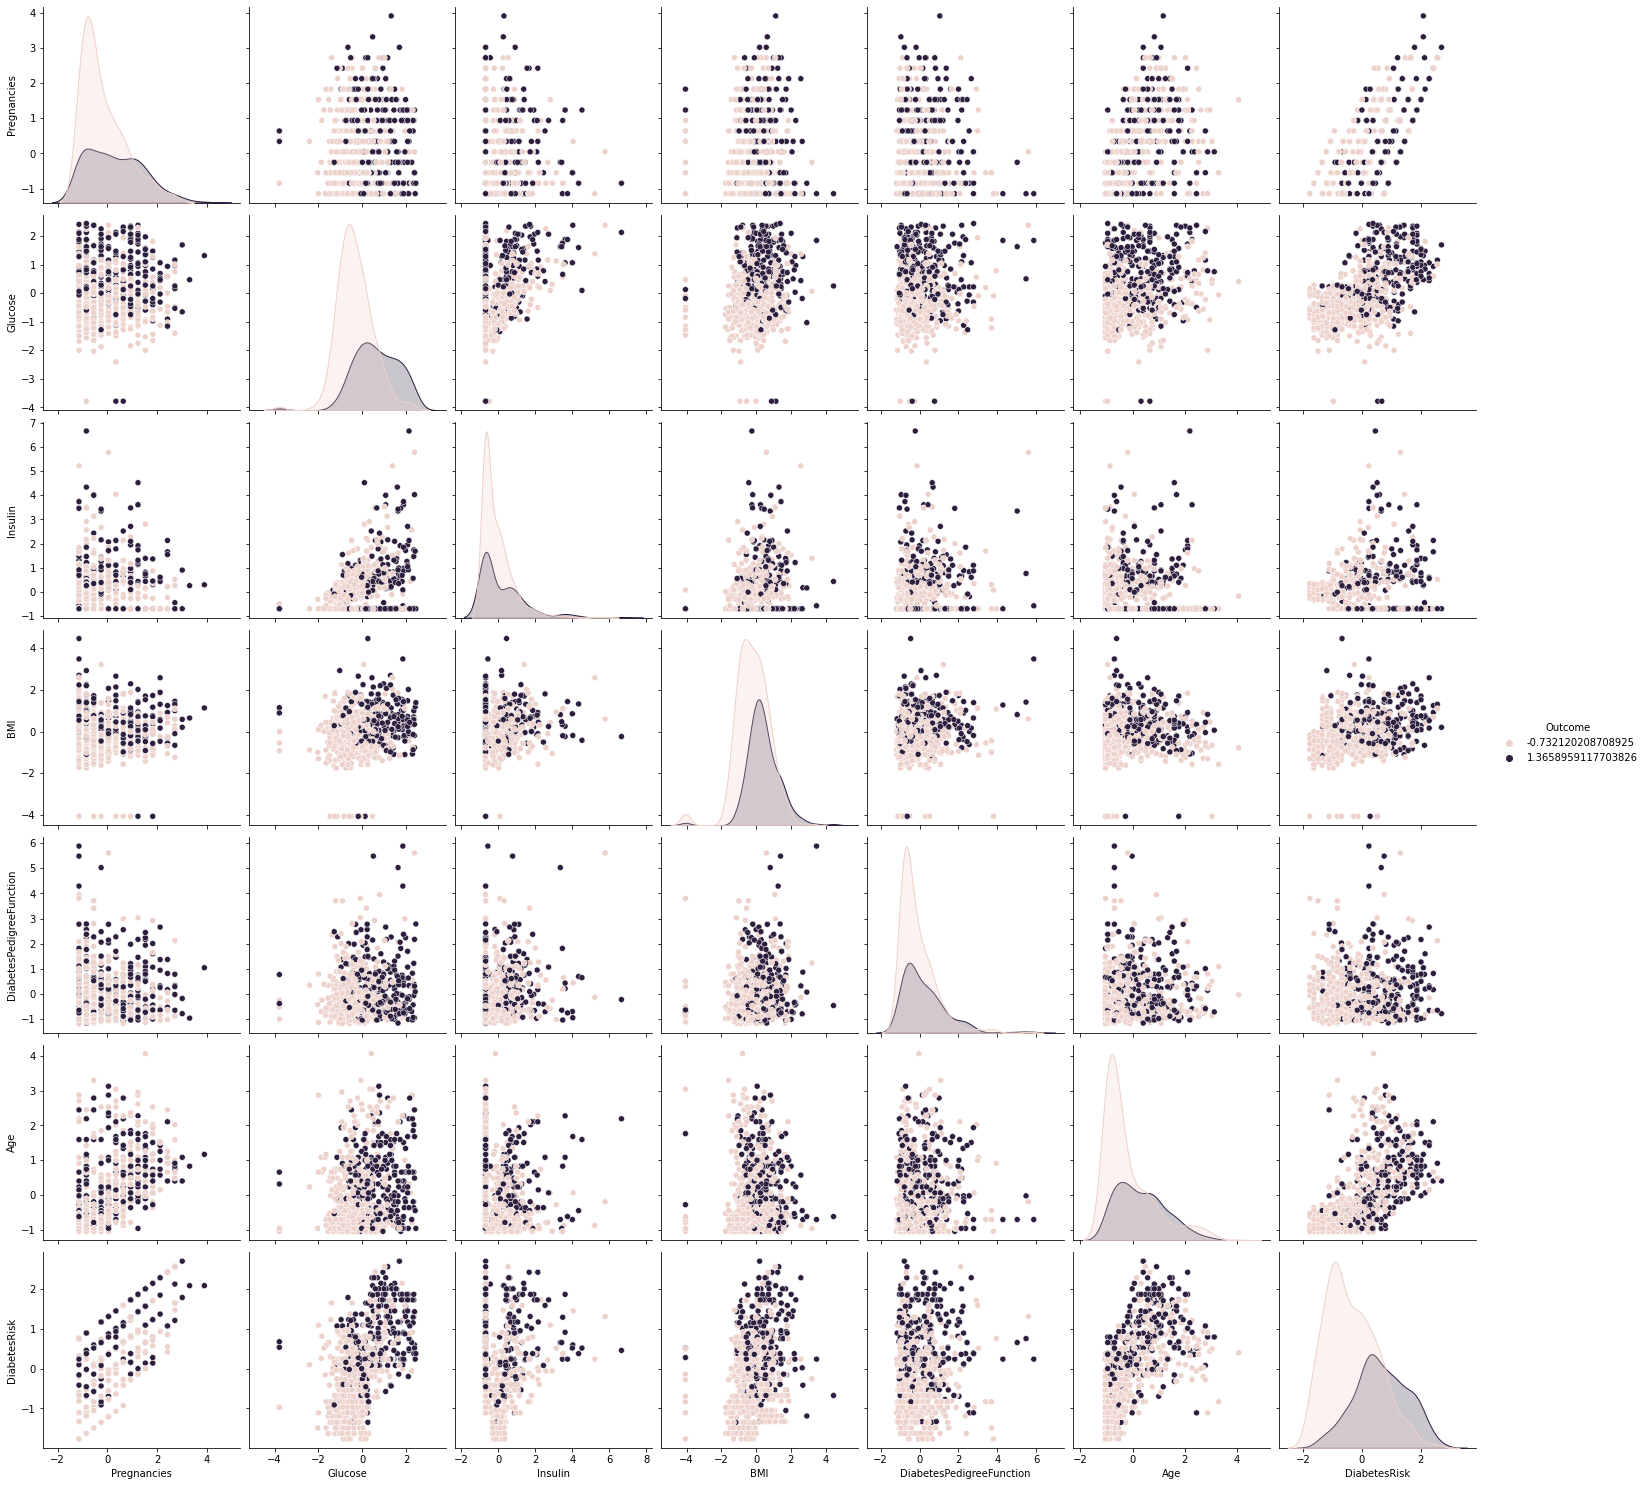

In [362]:
# Include only the columns that have sufficient correlation with the 'Outcome'.
cols = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
# Plot the relationship between all features using 'Outcome' as a visual metric.
sns.pairplot(scaled_df[cols], height=3.0, hue="Outcome")

## Save Dataset

In [359]:
df.to_csv("./data/diabetes_processed.csv", sep=",", columns=cols, float_format="%.3f")